In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import tensorflow.keras.layers as ly
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
train_b = True

In [ ]:
def RMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])*float(y_test[i]-y_pred[i]) for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))
def RMSE_list(y_test,y_pred):
    y_test = list(y_test); 
    y_test = [list(ln) for ln in y_test]
    y_pred = list(y_pred); 
    y_pred = [list(ln) for ln in y_pred]
    n = len(y_test); m = len(y_test[0])
    rmse_list = [np.square(float(y_test[i][j]-y_pred[i][j])) for i in range(n) for j in range(m)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data"
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

In [ ]:
data = []
#for y in range(2017,2023):
for y in [2021]:
  df = pd.read_csv(f"{DATA_DIR}/Total_Data_{y}_5m.csv")
  data.append(df)
data = pd.concat(data)



future_var = ['Global Horizontal UV Irradiance (280-400nm)','HourlyDryBulbTemperature']
for c in future_var:
  data[c+" Future"] = data[c].shift(-forecast_window).backfill()

used_var = ['N.Y.C.','Global Horizontal UV Irradiance (280-400nm)','HourlyDryBulbTemperature','Global Horizontal UV Irradiance (280-400nm) Future','HourlyDryBulbTemperature Future']
data = data[used_var].backfill();
data = data.dropna(how='any')

for c in used_var:
  #print(data[c].head(15));
  print(c,len(data[c].index),data[c].mean(),data[c].std())

print(data.head(5).to_string())
n = len(data.index)
t = int(7*24*(60/5))
num_var = len(used_var)

N.Y.C. 105102 5574.236639466899 1157.7346584901197
Global Horizontal UV Irradiance (280-400nm) 105102 9.306859028372438 14.709639920529495
HourlyDryBulbTemperature 105102 56.03220750925196 16.508206768495132
Global Horizontal UV Irradiance (280-400nm) Future 105102 9.306859028372438 14.709639920529495
HourlyDryBulbTemperature Future 105102 56.03478681325037 16.505866228760585
      N.Y.C.  Global Horizontal UV Irradiance (280-400nm)  HourlyDryBulbTemperature  Global Horizontal UV Irradiance (280-400nm) Future  HourlyDryBulbTemperature Future
0  4915.3086                                          0.0                 34.700000                                                 0.0                             33.0
1  4892.8174                                          0.0                 34.533333                                                 0.0                             33.0
2  4868.1533                                          0.0                 34.366667                               

In [ ]:
data

,N.Y.C.,Global Horizontal UV Irradiance (280-400nm),HourlyDryBulbTemperature,Global Horizontal UV Irradiance (280-400nm) Future,HourlyDryBulbTemperature Future
0,4915.3086,0.0,34.700000,0.0,33.000000
1,4892.8174,0.0,34.533333,0.0,33.000000
2,4868.1533,0.0,34.366667,0.0,33.000000
3,4856.5923,0.0,34.200000,0.0,33.000000
4,4829.3720,0.0,34.033333,0.0,33.000000
...,...,...,...,...,...
105097,4999.0645,0.0,48.687500,0.0,49.000000
105098,4970.3545,0.0,48.375000,0.0,49.000000
105099,4971.9966,0.0,48.062500,0.0,49.000000
105100,4916.0596,0.0,48.000000,0.0,49.000000


In [ ]:
m = 5574.113154123897;std = 1157.6820234795014
m_s = 9.305353909378894 ;std_s = 14.708926535057076
m_t = 56.030910041113;std_t = 16.507268780702415


m_list = [m,m_s,m_t,m_s,m_t]
std_list = [std,std_s,std_t,std_s,std_t]

def untransform_dataset_old(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    dataset=dataset.reshape(nv,ns*tw)
    dataset = np.array([(dataset[i]*stdi[i])+mi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else: 
    dataset=(dataset*stdi[0])+mi[0]
  return dataset

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].reshape(-1); dataX.append(a)
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)
def create_dataset_mult(dataset, hist_window=18,forecast_window=18,num_var=3):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(dataset.shape[0]-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].T
    dataX.append(a)
    
    e = dataset[i + hist_window:  i + hist_window+forecast_window, 0]
    dataY.append(e)
  return np.array(dataX), np.array(dataY)

def transform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==2:
    #ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    ns,nv = s
    dataset=dataset.T 
    dataset = np.array([(dataset[i]-mi[i])/stdi[i] for i in range(s[1])])
    dataset=dataset.T 
  else:
    dataset=(dataset-mi[0])/stdi[0] 
  return dataset
def untransform_dataset(dataset,mi=m_list,stdi=std_list):
  dataset=(dataset*stdi[0])+mi[0]
  return dataset  
dataset = data[used_var].values
dataset_xfr = transform_dataset(dataset)

x,y = create_dataset_mult(dataset_xfr,hist_window,forecast_window,num_var)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]

In [ ]:
# reshape input to be [samples, time steps, features]
#print(train.shape)
#train = np.reshape(train, (train.shape[0], num_var, train.shape[1]))
#valid = np.reshape(valid, (valid.shape[0], num_var, valid.shape[1]))

#Build Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               47600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 18)                1818      
                                                                 
Total params: 49,418
Trainable params: 49,418
Non-trainable params: 0
_________________________________________________________________


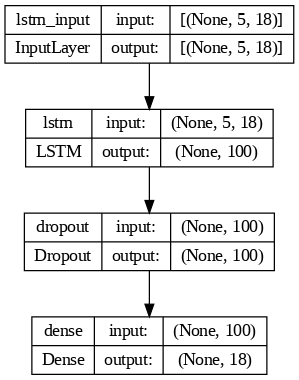

In [ ]:
import datetime
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Test"
def create_LSTM_model(LSTM_i = 4, dropout=0.3,
                      learning_rate=0.00005,var_num = 2,
                      hist_window=18,forecast_window=18):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    model = Sequential()
    model.add(LSTM(LSTM_i, input_shape=(var_num,hist_window)))
    model.add(Dropout(.1))
    model.add(Dense(forecast_window))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_LSTM_model(LSTM_i=100, var_num=num_var)
model.summary()
plot_model(model, show_shapes=True, dpi=90)

In [ ]:
#Fit Model
model_name = 'test_model_slope_with_solar_weather_future_100.h5'
print(datetime.datetime.now())
if train_b:
  model.fit(train, label_t, epochs=5, batch_size=1, verbose=2)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

2023-02-26 18:30:47.943615
Epoch 1/5
103086/103086 - 420s - loss: 0.0212 - 420s/epoch - 4ms/step
Epoch 2/5
103086/103086 - 428s - loss: 0.0102 - 428s/epoch - 4ms/step
Epoch 3/5
103086/103086 - 429s - loss: 0.0092 - 429s/epoch - 4ms/step
Epoch 4/5
103086/103086 - 431s - loss: 0.0083 - 431s/epoch - 4ms/step
Epoch 5/5
103086/103086 - 438s - loss: 0.0079 - 438s/epoch - 4ms/step


62/62 [==============================] - 3s 10ms/step
Test Score: 277.55 RMSE
Test Score: 93.92 RMSE


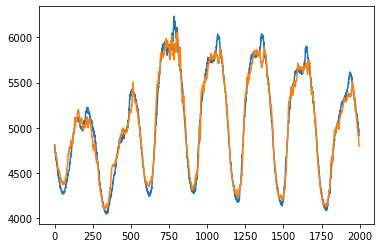

In [ ]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict(valid)

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()

# Load prediction with weather correction

---



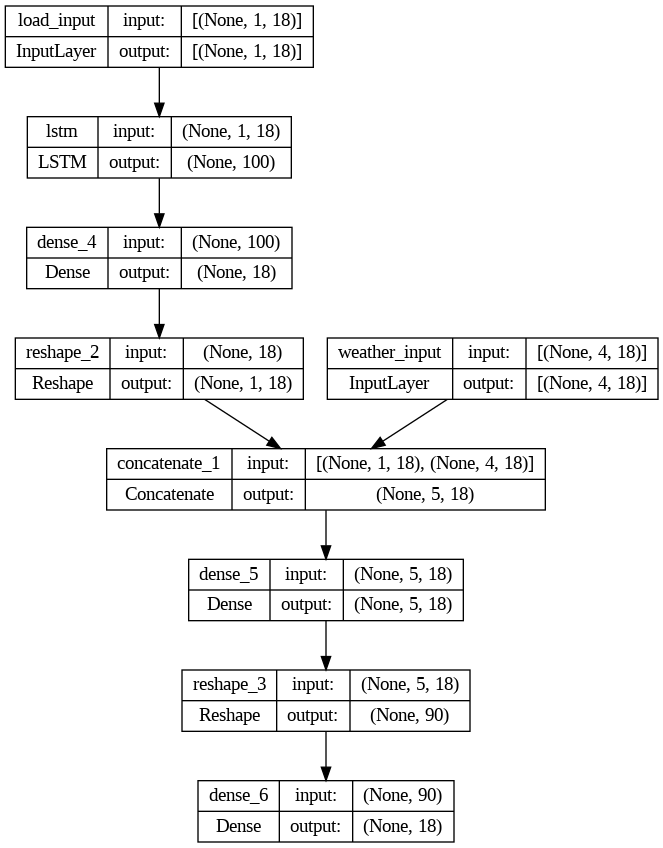

In [ ]:
def create_multi_input_model(recurrent_dropout=0.05,lstm_unit = 100,
                      learning_rate=0.00005,var_num = 4,
                      hist_window=18,forecast_window=18):
  
  load_input = ly.Input(shape=(1,hist_window), name='load_input')
  weather =  ly.Input(shape=(var_num,hist_window), name='weather_input')
  lstm = ly.LSTM(lstm_unit,  recurrent_dropout=recurrent_dropout, name = 'lstm')(load_input)
  lstm = ly.Dense(forecast_window)(lstm)
  lstm = ly.Reshape((1, hist_window))(lstm)
  all_input = ly.Concatenate(axis=1)([lstm, weather])
  forcast = ly.Dense(forecast_window)(all_input)
  forcast = ly.Reshape(((var_num+1)*hist_window,))(forcast) # can use a convolution layer here? 
  forcast = ly.Dense(forecast_window)(forcast)

  model = Model(inputs = [load_input, weather], outputs = [forcast])

  return model
model = create_multi_input_model() 
plot_model (model, show_shapes=True)

In [ ]:
# def model_train(model, load_input, weather_input, load_target):
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Test"
model_name = 'test_LSTM_multi_input.h5'

# model = create_multi_input_model()
model.compile(loss='mean_squared_error', optimizer='adam')
model_hist = model.fit([train[:,0:1,:], train[:,1:,:]], label_t, epochs=5)
model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')


Epoch 1/5
3222/3222 [==============================] - 29s 7ms/step - loss: 0.0209
Epoch 2/5
3222/3222 [==============================] - 20s 6ms/step - loss: 0.0064
Epoch 3/5
3222/3222 [==============================] - 23s 7ms/step - loss: 0.0059
Epoch 4/5
3222/3222 [==============================] - 25s 8ms/step - loss: 0.0058
Epoch 5/5
3222/3222 [==============================] - 22s 7ms/step - loss: 0.0055


In [ ]:
label_t

array([[-0.81706128, -0.82611644, -0.8323508 , ..., -0.98186128,
        -0.98890691, -0.98899018],
       [-0.82611644, -0.8323508 , -0.83693807, ..., -0.98890691,
        -0.98899018, -0.99038987],
       [-0.8323508 , -0.83693807, -0.86622072, ..., -0.98899018,
        -0.99038987, -1.00792716],
       ...,
       [-0.6331562 , -0.62958968, -0.63598712, ..., -0.80613747,
        -0.8437249 , -0.83035077],
       [-0.62958968, -0.63598712, -0.65844285, ..., -0.8437249 ,
        -0.83035077, -0.85820902],
       [-0.63598712, -0.65844285, -0.70260671, ..., -0.83035077,
        -0.85820902, -0.85805207]])

In [ ]:
pred = model.predict([train[:,0:1,:], train[:,1:,:]])
pred

3222/3222 [==============================] - 10s 3ms/step


array([[-0.8134092 , -0.82355434, -0.836954  , ..., -0.94397354,
        -0.94920963, -0.9508841 ],
       [-0.82062274, -0.8300347 , -0.8422722 , ..., -0.941254  ,
        -0.945491  , -0.94574267],
       [-0.8331659 , -0.84055364, -0.8519318 , ..., -0.93393666,
        -0.9359143 , -0.93583864],
       ...,
       [-0.6037256 , -0.61784023, -0.639832  , ..., -0.81488514,
        -0.8221731 , -0.83048785],
       [-0.626599  , -0.6424472 , -0.65991795, ..., -0.84752214,
        -0.8588777 , -0.8650211 ],
       [-0.644195  , -0.6562947 , -0.66944325, ..., -0.84303856,
        -0.849002  , -0.85890704]], dtype=float32)

62/62 [==============================] - 0s 3ms/step
Test Score: 306.32 RMSE
Test Score: 116.53 RMSE


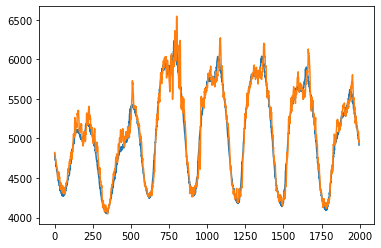

In [ ]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict([valid[:,0:1,:], valid[:,1:,:]])

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()